In [1]:
# import useful libraries and packages
import pandas as pd

## Reading data

### Define functions to read demand/traffic data

In [2]:
######################
##  Reading traffic data
#######################
def get_traffic_data():
    input_file = 'C:/Users/AbdouAA/Work Folders/Documents/GitHub/k2-respunkt/data/RST_2015_v38_42.csv'
    traffic_data = pd.read_csv(input_file, delimiter=';')
    return traffic_data


######################
##  Reading demand data
#######################
def get_demand_data():
    # load dataset
    input_file = 'C:/Users/AbdouAA/Work Folders/Documents/GitHub/k2-respunkt/data/OD_data_dynamic.xlsx'
    df_static = pd.read_excel(input_file, sheet_name='Static', index_col=0, header=0)

    # Extract headers and index from the static data
    headers = df_static.columns
    index = df_static.index

    # Number of time periods (every 15 minutes during a full day)
    nb_time_periods = int(24 * 60 / 15)  # 96 periods

    # Initialize a dictionary to store DataFrames for each time period
    df_sheets = {}

    # Read specific sheets by index
    for t in range(nb_time_periods):
        sheet_name = f"Sheet{t+1}"  # Assuming sheet names are "Sheet1", "Sheet2", ..., "Sheet96"
        df_temp = pd.read_excel(input_file, sheet_name=sheet_name, header=None)  # Read without headers
        
        # Assign the headers and index from the static data
        df_temp.columns = headers
        df_temp.index = index
        
        # Store the DataFrame in the dictionary
        df_sheets[t] = df_temp
    return df_sheets

import pandas as pd 

## Function to update/adjust static OD data for the specific studied line between Nyh and Bål
# Groups of stations
#C_stations = ['Äs', 'Åbe', 'Sst', 'Cst', 'Ke'] # central stations
def update_OD_Nyh_Bal(df):
    # Define station groups
    R35_stations = ['Nyh', 'Gdv', 'Ngd', 'Öso', 'Ssä', 'Hfa', 'Ts', 'Kda', 'Vhe', 'Jbo', 'Hnd', 'Skg', 'Tåd', 'Fas'] # eastern/right stations of line 35
    L35_stations = ['Sub', 'Spå', 'Bkb', 'Jkb', 'Khä', 'Kän', 'Bro', 'Bål'] # western/left stations of line 35
    R36_stations = ['Söc', 'Söd', 'Söu', 'Tul', 'Tu', 'Öte', 'Flb', 'Gn', 'Hu', 'Mö', 'Rön', 'Sta'] # eastern/right stations of line 36
    L36_stations = ['Sol', 'So', 'Udl', 'Upv', 'U', 'Hel', 'Hgv' , 'Kn', 'Mr', 'Nvk', 'Rs', 'R'] # western/left stations of line 36

    # Create a copy of the DataFrame to avoid modifying the original
    df_updated = df.copy()
    
    # Process trips from 35L to 36L
    for origin in L35_stations:
        for destination in L36_stations:
            df_updated.at[origin, 'Ke'] += df.at[origin, destination]
            df_updated.at[origin, destination] = 0
    
    # Process trips from 35L to 36R
    for origin in L35_stations:
        for destination in R36_stations:
            df_updated.at[origin, 'Äs'] += df.at[origin, destination]
            df_updated.at[origin, destination] = 0
            
    # Process trips from 35R to 36L
    for origin in R35_stations:
        for destination in L36_stations:
            df_updated.at[origin, 'Ke'] += df.at[origin, destination]
            df_updated.at[origin, destination] = 0
    
    # Process trips from 35R to 36R
    for origin in R35_stations:
        for destination in R36_stations:
            df_updated.at[origin, 'Äs'] += df.at[origin, destination]
            df_updated.at[origin, destination] = 0
    
    # Process trips from 36L to 35L
    for origin in L36_stations:
        for destination in L35_stations:
            df_updated.at['Ke', destination] += df.at[origin, destination]
            df_updated.at[origin, destination] = 0
            
    # Process trips from 36L to 35R
    for origin in L36_stations:
        for destination in R35_stations:
            df_updated.at['Äs', destination] += df.at[origin, destination]
            df_updated.at[origin, destination] = 0
            
    # Process trips from 36R to 35L
    for origin in R36_stations:
        for destination in L35_stations:
            df_updated.at['Ke', destination] += df.at[origin, destination]
            df_updated.at[origin, destination] = 0
    
    # Process trips from 36R to 35R
    for origin in R36_stations:
        for destination in R35_stations:
            df_updated.at['Äs', destination] += df.at[origin, destination]
            df_updated.at[origin, destination] = 0
    
    return df_updated

### Read traffic data

In [3]:
# read traffic data
df_traffic = get_traffic_data()

### Read demand data

In [4]:
# read demand data
df_demand = get_demand_data()

# Data exploration and preprocessing

### Traffic data

In [5]:
# List of columns to drop
columns_to_drop = [
    "Tågordning uppdrag",
    "Tågslag",
    "Avgångsplats",
    "Ankomstplats",
    "Första platssignatur för uppdrag",
    "Sista platssignatur för uppdrag",
    "Inställelseorsakskod",
    "Inställelseorsak",
    "Dragfordonsid",
    "Framförda tågkm",
    "Rapporterad tågvikt",
    "Rapporterad tåglängd",
    "Antal rapporterade hjulaxlar",
    "Antal rapporterade vagnar",
    "Inställtflagga"
]
# drop columns
df_traffic_filtered = df_traffic.drop(columns_to_drop, axis=1)

# rename the remaining columns, to remove space so that I can use pandas indexing
# Dictionary mapping old column names to new column names
columns_rename = {
    "Tåguppdrag": "Taguppdrag",
    "Tågnr": "Tagnr",
    "Datum (PAU)": "Datum",
    "UppehållstypAvgång": "UppehallstypAvgang",
    "UppehållstypAnkomst": "UppehallstypAnkomst",
    "Delsträckanummer": "Delstrackanummer",
    "Första platssignatur": "Forsta_platssignatur",
    "Sista platssignatur": "Sista_platssignatur",
    "Från platssignatur": "Fran_platssignatur",
    "Till platssignatur": "Till_platssignatur",
    "Sträcka med riktning": "Stracka_med_riktning",
    "Ankomsttid": "Ankomsttid",
    "Avgångstid": "Avgangstid",
    "Planerad ankomsttid": "Planerad_ankomsttid",
    "Planerad avgångstid": "Planerad_avgangstid",
    "Planeringsstatus": "Planeringsstatus"
}

# Rename the columns
df_traffic_renamed_all = df_traffic_filtered.rename(columns=columns_rename)

df_traffic_renamed_all['Ankomsttid'] = pd.to_datetime(df_traffic_renamed_all['Ankomsttid'], errors='coerce')
df_traffic_renamed_all['Avgangstid'] = pd.to_datetime(df_traffic_renamed_all['Avgangstid'], errors='coerce')
df_traffic_renamed_all['Planerad_ankomsttid'] = pd.to_datetime(df_traffic_renamed_all['Planerad_ankomsttid'], errors='coerce')
df_traffic_renamed_all['Planerad_avgangstid'] = pd.to_datetime(df_traffic_renamed_all['Planerad_avgangstid'], errors='coerce')

#### Remove/merge observations at intermediate non-stopping points (points not in the studied line)

In [6]:
# Initial filtering: Remove rows where both 'UppehallstypAvgang' and 'UppehallstypAnkomst' are 'Passage'
df_traffic_renamed = df_traffic_renamed_all[
    ~((df_traffic_renamed_all['UppehallstypAvgang'] == 'Passage') & 
      (df_traffic_renamed_all['UppehallstypAnkomst'] == 'Passage'))
]

# Identify rows with 'Passage' in either 'UppehallstypAvgang' or 'UppehallstypAnkomst'
passage_rows_avg = df_traffic_renamed[df_traffic_renamed['UppehallstypAvgang'] == 'Passage']
passage_rows_ank = df_traffic_renamed[df_traffic_renamed['UppehallstypAnkomst'] == 'Passage']

# Find the common train groups with 'Passage' in both avgång and ankomst
unique_ids = set(zip(passage_rows_avg['Taguppdrag'], passage_rows_avg['Datum'], passage_rows_avg['Tagnr'])) & \
             set(zip(passage_rows_ank['Taguppdrag'], passage_rows_ank['Datum'], passage_rows_ank['Tagnr']))

merged_rows = []

# Iterate over each unique (Taguppdrag, Datum, Tagnr) tuple
for tag_id, datum, tagnr in unique_ids:
    # Get the corresponding rows
    rows_avg = passage_rows_avg[(passage_rows_avg['Taguppdrag'] == tag_id) & 
                                (passage_rows_avg['Datum'] == datum) & 
                                (passage_rows_avg['Tagnr'] == tagnr)].sort_values(by="Delstrackanummer")
    
    rows_ank = passage_rows_ank[(passage_rows_ank['Taguppdrag'] == tag_id) & 
                                (passage_rows_ank['Datum'] == datum) & 
                                (passage_rows_ank['Tagnr'] == tagnr)].sort_values(by="Delstrackanummer")
    
    # Iterate over each row in the avgång and ankomst sets
    for i in range(len(rows_ank)):
        # Merge the rows according to the specified rules
        merged_row = rows_avg.iloc[i].copy()
        merged_row['UppehallstypAvgang'] = rows_ank['UppehallstypAvgang'].iloc[i]
        merged_row['UppehallstypAnkomst'] = rows_avg['UppehallstypAnkomst'].iloc[i]
        merged_row['Delstrackanummer'] = rows_ank['Delstrackanummer'].iloc[i]
        merged_row['Fran_platssignatur'] = rows_ank['Fran_platssignatur'].iloc[i]
        merged_row['Till_platssignatur'] = rows_avg['Till_platssignatur'].iloc[i]
        merged_row['Ankomsttid'] = rows_avg['Ankomsttid'].iloc[i]
        merged_row['Avgangstid'] = rows_ank['Avgangstid'].iloc[i]
        merged_row['Planerad_ankomsttid'] = rows_avg['Planerad_ankomsttid'].iloc[i]
        merged_row['Planerad_avgangstid'] = rows_ank['Planerad_avgangstid'].iloc[i]

        # Add the merged row to the list
        merged_rows.append(merged_row)

# Create a DataFrame from the merged rows
merged_rows_df = pd.DataFrame(merged_rows)

# Remove the original 'Passage' rows from the DataFrame
traffic_data_filtered = df_traffic_renamed[
    ~((df_traffic_renamed['UppehallstypAvgang'] == 'Passage') | 
      (df_traffic_renamed['UppehallstypAnkomst'] == 'Passage'))
]

# Add the merged rows back into the DataFrame
traffic_data_filtered = pd.concat([traffic_data_filtered, merged_rows_df], ignore_index=True)

# Sort by 'Datum', 'Taguppdrag', 'Tagnr', and 'Delstrackanummer'
traffic_data_filtered.sort_values(by=['Datum', 'Taguppdrag', 'Tagnr', 'Delstrackanummer'], inplace=True)

# Re-adjust 'Delstrackanummer' within each group to be consecutive
traffic_data_filtered['Delstrackanummer'] = traffic_data_filtered.groupby(['Datum', 'Taguppdrag', 'Tagnr']).cumcount() + 1

# Extract the date part only
dates_planned = traffic_data_filtered['Planerad_avgangstid'].dt.date

# Identify trains departing before 2 am on 2015-09-14
early_morning_trains = traffic_data_filtered[
    (dates_planned == pd.to_datetime('2015-09-14').date()) & 
    (traffic_data_filtered['Planerad_avgangstid'].dt.hour < 2)
]

# Remove the identified trains
traffic_data_filtered = traffic_data_filtered.loc[~traffic_data_filtered.index.isin(early_morning_trains.index)]


## correct missing Ankomsttid when Avgangstid exist using Avgangstid and Planerad_avgangstid and Planerad_ankomsttid
# Step 1: Filter out only planned (non-cancelled) trains
df_traffic_no_cancellation = traffic_data_filtered[traffic_data_filtered["Planeringsstatus"] == "P"].copy()

# Step 2: Correct missing Ankomsttid using Avgangstid
# Filter rows where Ankomsttid is missing but Avgangstid exists
missing_arrival_mask = df_traffic_no_cancellation['Ankomsttid'].isna() & df_traffic_no_cancellation['Avgangstid'].notna()

# Calculate the difference between Planerad_ankomsttid and Planerad_avgangstid (in minutes)
df_traffic_no_cancellation['planned_runtime'] = (df_traffic_no_cancellation['Planerad_ankomsttid'] - df_traffic_no_cancellation['Planerad_avgangstid']).dt.total_seconds() / 60

# Calculate the expected Ankomsttid by adding the time difference to Avgangstid
df_traffic_no_cancellation.loc[missing_arrival_mask, 'Ankomsttid'] = df_traffic_no_cancellation.loc[missing_arrival_mask, 'Avgangstid'] + pd.to_timedelta(df_traffic_no_cancellation.loc[missing_arrival_mask, 'planned_runtime'], unit='m')

actual_or_planned = 'planned'
if actual_or_planned != 'planned':
    # if actual

    # Step 1: Group the data by 'Datum', 'Taguppdrag', 'Tagnr'
    grouped = df_traffic_no_cancellation.groupby(['Datum', 'Taguppdrag', 'Tagnr'])

    # Step 2: Identify groups where any 'Ankomsttid' or 'Avgangstid' is missing
    groups_with_missing_values = grouped.filter(lambda group: group[['Ankomsttid', 'Avgangstid']].isnull().any().any())

    # Step 3: Remove those groups from the original DataFrame
    df_traffic_no_cancellation = df_traffic_no_cancellation[~df_traffic_no_cancellation.index.isin(groups_with_missing_values.index)]

    # Step 5: Reset index if needed
    df_traffic_no_cancellation = df_traffic_no_cancellation.reset_index(drop=True)

## 1. Line passenger punctuality

### 1.1. OTP (excl. cancellations) for different delay thresholds and time periods

### definition of get_OTP

In [7]:
# calculate OTP in seconds
def get_OTP(df_traffic, include_cancellations=False):
    """
    Calculate on-time performance based on traffic data (AVL).

    Parameters:
    df_traffic (DataFrame): The traffic data containing arrival and departure information.

    Returns:
    DataFrame: Filtered data with OTP calculations.
    """

    # Keep rows where UppehållstypAnkomst is "Sista", i.e., last arrival
    df_OTP = df_traffic[df_traffic['UppehallstypAnkomst'] == 'Sista'].copy()

    # Ensure 'Ankomsttid' and 'Planerad ankomsttid' are datetime types
    df_OTP['Datum'] = pd.to_datetime(df_OTP['Ankomsttid'], errors='coerce')
    df_OTP['Ankomsttid'] = pd.to_datetime(df_OTP['Ankomsttid'], errors='coerce')
    df_OTP['Planerad_ankomsttid'] = pd.to_datetime(df_OTP['Planerad_ankomsttid'], errors='coerce')

    # If cancelled trains are not included, drop rows where conversion failed (i.e., NaN values), cancelled trains
    # if(not include_cancellations):
    #     df_OTP = df_OTP.dropna(subset=['Ankomsttid'])

    # Calculate punctuality delay at the destination station (in seconds)
    df_OTP['OTP_min'] = (df_OTP['Ankomsttid'] - df_OTP['Planerad_ankomsttid']).dt.total_seconds()/60.

    return df_OTP

In [8]:
df_OTP = get_OTP(df_traffic_no_cancellation)

### definition of the plotting function plot_OTP

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_OTP(df_OTP_sec, periodicity='all'):
    """
    Plot on-time performance based on delay thresholds.

    Parameters:
    df_OTP_sec (DataFrame): DataFrame containing OTP calculations in seconds.
    periodicity (str): 'all' for overall, 'day' for daily variations, 'hour' for hourly variations.

    Returns:
    None
    """

    # Define a range of delay thresholds up to 30 minutes
    delay_thresholds = np.linspace(0, 30, 100)
    OTP_within_threshold = []

    # Calculate the percentage of trains within each delay threshold
    total_valid_arrivals = df_OTP_sec['OTP_min'].count() # skip cancellations
    print(total_valid_arrivals) 
    
    for threshold in delay_thresholds:
        num_within_threshold = np.sum(df_OTP_sec['OTP_min'] <= threshold) # number of arrivals to final station within threshold (in minutes)
        OTP_within_threshold.append((num_within_threshold / total_valid_arrivals) * 100)


    if periodicity == 'all':
        # Plotting the results for overall OTP
        plt.figure(figsize=(12, 8))
        plt.plot(delay_thresholds, OTP_within_threshold, linestyle='-', label='OTP (excl. cancellations)')
        plt.legend()
        plt.xlabel('Delay threshold (in minutes)', fontsize=15)
        plt.ylabel('Percentage of on-time trains (in %)', fontsize=15)
        plt.title('Variation of OTP scores for different delay thresholds', fontsize=16)
        plt.legend(loc='lower right', fontsize=14)
        plt.xticks(range(0, 31, 5))
        plt.grid(True)
        plt.show()

    elif periodicity == 'day':
        # Calculate average OTP for each weekday (Monday to Sunday)
        weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
        df_OTP_sec['Weekday'] = df_OTP_sec['Datum'].dt.day_name()
        df_weekday_OTP = pd.DataFrame(columns=weekdays, index=np.arange(len(delay_thresholds)))

        for i, threshold in enumerate(delay_thresholds):
            for weekday in weekdays:
                # Filter data for the current weekday and delay threshold
                weekday_data = df_OTP_sec[(df_OTP_sec['Weekday'] == weekday) & (df_OTP_sec['OTP_min'] <= threshold)]
                df_weekday_OTP.loc[i, weekday] = len(weekday_data) / len(df_OTP_sec[df_OTP_sec['Weekday'] == weekday]) * 100

        # Plotting daily variation OTP
        plt.figure(figsize=(12, 8))
        for weekday in weekdays:
            plt.plot(delay_thresholds, df_weekday_OTP.loc[:, weekday], label=weekday)

        #plt.plot(delay_thresholds, OTP_within_threshold, linestyle='-', label='All')

        plt.legend(title='Time periods')
        plt.xlabel('Delay threshold (in minutes)', fontsize=15)
        plt.ylabel('Percentage of on-time trains (in %)', fontsize=15)
        plt.title('Variation of OTP scores for different week days', fontsize=16)
        plt.legend(loc='lower right', fontsize=14)
        plt.xticks(range(0, 31, 5))
        plt.grid(True)
        plt.show()

    elif periodicity == 'hour':

# Categorize hours into specific periods
        df_OTP_sec['Hour'] = df_OTP_sec['Ankomsttid'].dt.hour
        hour_bins = [6, 9, 15, 18]
        hour_labels = ['Morning peak', 'Off-peak (midday)', 'Afternoon peak']
        colors = ['red', 'green', 'blue']

        # Use pd.cut to categorize each hour into the appropriate period
        df_OTP_sec['Hour Period'] = pd.cut(df_OTP_sec['Hour'], bins=hour_bins, labels=hour_labels, ordered=False)

        # Calculate average OTP for each hour period
        df_hourly_OTP = pd.DataFrame(columns=['OTP Percentage'], index=hour_labels)

        for period in hour_labels:
            # Filter data for the current hour period and calculate OTP percentage
            period_data = df_OTP_sec[df_OTP_sec['Hour Period'] == period]
            OTP_percentage = []
            for threshold in delay_thresholds:
                num_within_threshold = np.sum(period_data['OTP_min'] <= threshold)
                OTP_percentage.append((num_within_threshold / len(period_data)) * 100)
            df_hourly_OTP.loc[period, 'OTP Percentage'] = OTP_percentage

        # Plotting hourly variation OTP
        plt.figure(figsize=(12, 8))
        for i, period in enumerate(hour_labels):
            plt.plot(delay_thresholds, df_hourly_OTP.loc[period, 'OTP Percentage'], label=period, color=colors[i])

        plt.plot(delay_thresholds, OTP_within_threshold, linestyle='-', label='All day', color='gray')
        plt.xlabel('Delay threshold (in minutes)', fontsize=15)
        plt.ylabel('Percentage of on-time trains (in %)', fontsize=15)
        plt.title('Variation of OTP scores for different time periods', fontsize=16)
        plt.legend(loc='lower right', fontsize=14)
        plt.xticks(range(0, 31, 5))
        plt.grid(True)
        plt.show()

    else:
        print("Invalid periodicity option. Choose from 'all', 'day', or 'hour'.")

4695


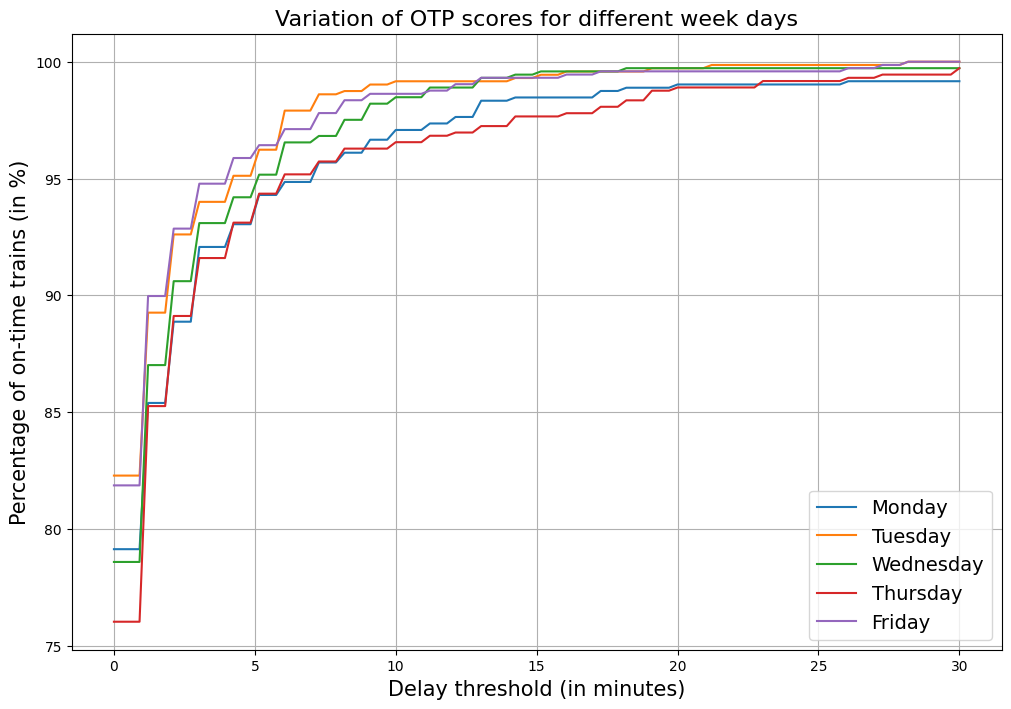

4695


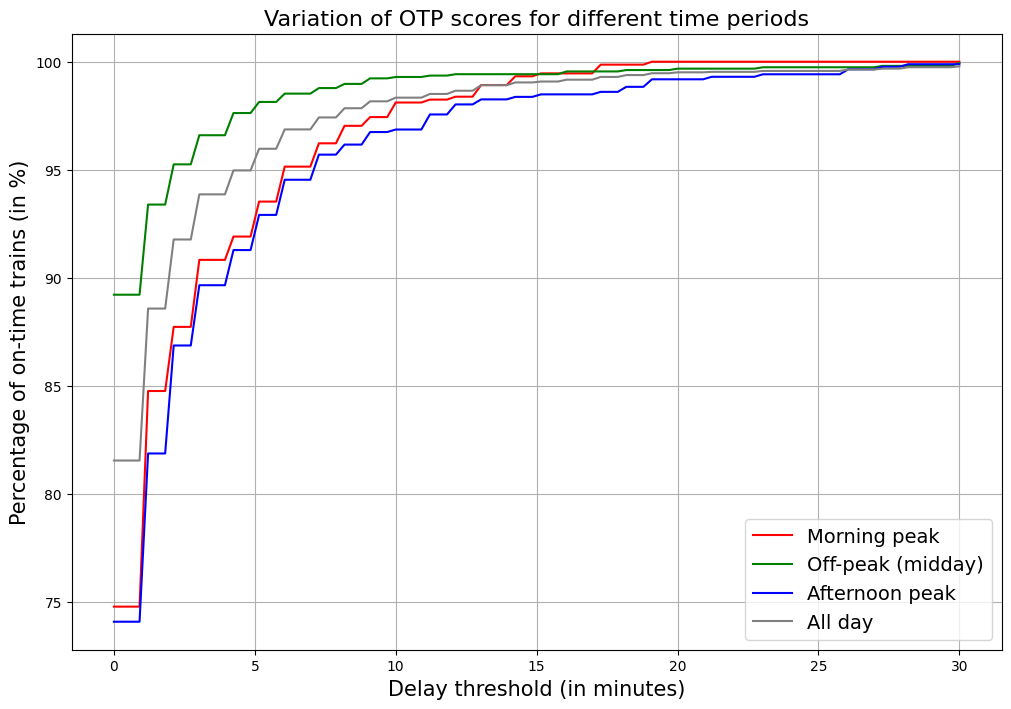

In [10]:
# plot the OTP monthly for different thresholds
plot_OTP(df_OTP, periodicity='day')
plot_OTP(df_OTP, periodicity='hour')

### 1.2. CPM (incl. cancellations)

In [11]:
OTP_incl_cancel = get_OTP(traffic_data_filtered, include_cancellations=True)

In [14]:
def plot_OTP_CPM(df_incl):
    """
    Plot on-time performance based on delay thresholds.

    Parameters:
    df_OTP_sec (DataFrame): DataFrame containing OTP calculations in seconds.
    periodicity (str): 'all' for overall, 'day' for daily variations, 'hour' for hourly variations.

    Returns:
    None
    """

    # Define a range of delay thresholds up to 30 minutes
    delay_thresholds = np.linspace(0, 30, 100)
    OTP_within_threshold_incl = []
    OTP_within_threshold_excl = []

    # Calculate the percentage of trains within each delay threshold
    total_valid_arrivals = df_incl['OTP_min'].count() # skip cancellations
    total_arrivals = len(df_incl['OTP_min'])
    print(total_valid_arrivals)
    print(total_arrivals)
    for threshold in delay_thresholds:
        # including cancellations
        num_within_threshold_incl = np.sum(df_incl['OTP_min'] <= threshold) # number of arrivals to final station within threshold (in minutes)
        OTP_within_threshold_incl.append((num_within_threshold_incl / total_arrivals) * 100)
        # excluding cancellations
        num_within_threshold_excl = np.sum(df_incl['OTP_min']  <= threshold) # number of arrivals to final station within threshold (in minutes)
        OTP_within_threshold_excl.append((num_within_threshold_excl / total_valid_arrivals) * 100)


    # Plotting the results for overall OTP
    plt.figure(figsize=(12, 8))
    plt.plot(delay_thresholds, OTP_within_threshold_incl, label='Cancellations included (CPM)')
    plt.plot(delay_thresholds, OTP_within_threshold_excl, label='Cancellations excluded (OTP)')
    plt.legend()
    plt.xlabel('Delay threshold (in minutes)', fontsize=15)
    plt.ylabel('Percentage of on-time trains (in %)', fontsize=15)
    plt.title('Variation of OTP and CPM scores for different delay thresholds', fontsize=16)
    plt.legend(loc='lower right', fontsize=14)
    plt.xticks(range(0, 31, 5))
    plt.grid(True)
    plt.show()


4800
5371


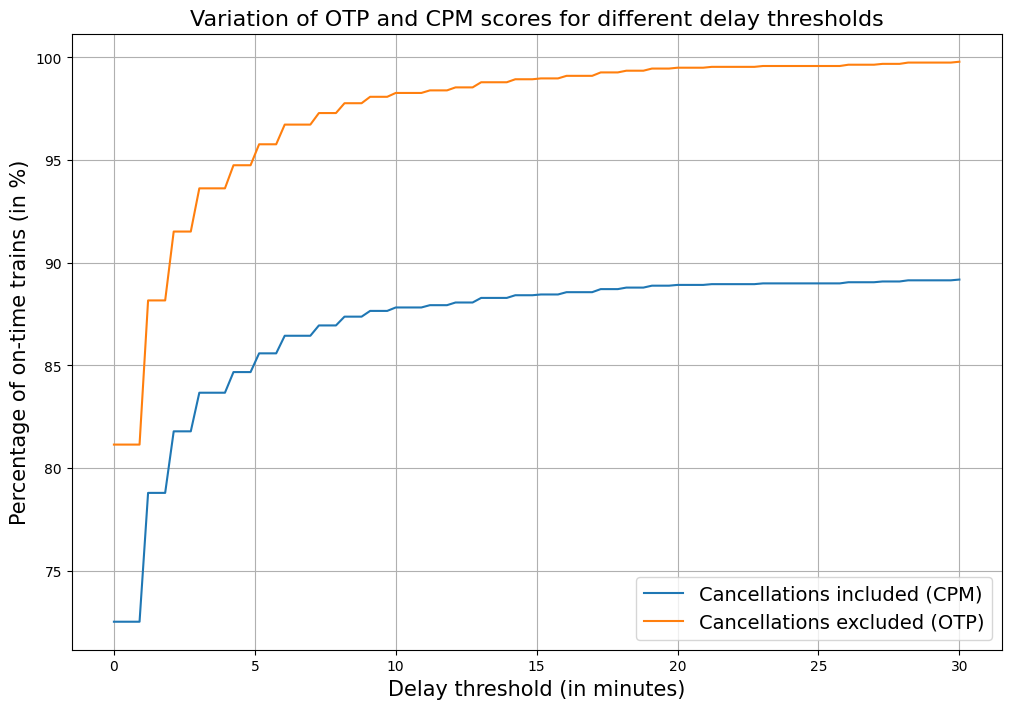

In [15]:
plot_OTP_CPM(OTP_incl_cancel)